# 04 — Evaluación estadística de checkpoints (FIX)

- Evalúa varios checkpoints en el **mismo** `test_split.csv`
- Métricas + Bootstrap CI (95%)
- McNemar entre pares (predicciones pareadas)


In [4]:
import os, json
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from statsmodels.stats.contingency_tables import mcnemar
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

OUT_DIR  = r"C:\Users\User\Downloads\COVID_HYBRID_experiment2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

with open(os.path.join(OUT_DIR, "config_runtime.json"), "r", encoding="utf-8") as f:
    cfg = json.load(f)
IMG_SIZE = cfg["IMG_SIZE"]; BATCH_SIZE = cfg["BATCH_SIZE"]; NUM_WORKERS = cfg["NUM_WORKERS"]

test_df = pd.read_csv(os.path.join(OUT_DIR, "test_split.csv"))
print("Test size:", len(test_df))

CHECKPOINTS = {
    "Modelo_A": os.path.join(OUT_DIR, "runs", "Modelo_A_baseline", "best_hybrid_exp2.pt"),
    "Modelo_B": os.path.join(OUT_DIR, "runs", "Modelo_B_stable",   "best_hybrid_exp2.pt"),
    "Modelo_C": os.path.join(OUT_DIR, "runs", "Modelo_C_fast_lr",  "best_hybrid_exp2.pt"),
}


N_BOOTSTRAP = 1000


Test size: 1435


In [5]:
class XRayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True); self.transform = transform
    def __len__(self): 
        return len(self.df)
    def __getitem__(self, idx):
        p = self.df.iloc[idx]["path"]; y = int(self.df.iloc[idx]["label"])
        img = Image.open(p).convert("L").convert("RGB")
        if self.transform: 
            img = self.transform(img)
        return img, y, p   # <- ahora devuelve 3 cosas

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3,[0.5]*3)
])

test_loader = DataLoader(
    XRayDataset(test_df, eval_tfms),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=(DEVICE=="cuda")
)



In [10]:
import torch.nn as nn
from torchvision.models import resnext50_32x4d, vit_b_16

supports_imgsize = False
try:
    _ = vit_b_16(weights=None, image_size=224)
    supports_imgsize = True
except TypeError:
    supports_imgsize = False

class HybridRxViT(nn.Module):
    def __init__(self, n_classes=2, img_size=224):
        super().__init__()
        self.resnext = resnext50_32x4d(weights=None)
        self.vit     = vit_b_16(weights=None, image_size=img_size) if supports_imgsize else vit_b_16(weights=None)

        res_feat_dim = self.resnext.fc.in_features
        self.resnext.fc = nn.Identity()

        vit_feat_dim = self.vit.heads.head.in_features
        self.vit.heads.head = nn.Identity()

        fused_dim = res_feat_dim + vit_feat_dim
        self.classifier = nn.Sequential(
            nn.LayerNorm(fused_dim),
            nn.Dropout(0.4),
            nn.Linear(fused_dim, 512), nn.ReLU(True),
            nn.Dropout(0.4),
            nn.Linear(512, n_classes)
        )

        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        f = torch.cat([self.resnext(x), self.vit(x)], dim=1)
        return self.classifier(f)

def build_model():
    return HybridRxViT(n_classes=2, img_size=IMG_SIZE)

def extract_state_dict(ckpt):
    # Soporta varios formatos comunes
    if isinstance(ckpt, dict):
        for k in ["state_dict", "model_state_dict", "model_state", "model"]:
            if k in ckpt and isinstance(ckpt[k], dict):
                sd = ckpt[k]
                break
        else:
            sd = ckpt
    else:
        sd = ckpt

    # quitar prefijo 'module.' si existiera
    if isinstance(sd, dict):
        new_sd = {}
        for k, v in sd.items():
            nk = k.replace("module.", "") if k.startswith("module.") else k
            new_sd[nk] = v
        sd = new_sd
    return sd


In [12]:
def evaluate_checkpoint(ckpt_path, thresh=0.5):
    model = build_model().to(DEVICE)

    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    state_dict = extract_state_dict(ckpt)

    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    if len(missing) > 0 or len(unexpected) > 0:
        print(f"[{os.path.basename(ckpt_path)}] Missing={len(missing)} Unexpected={len(unexpected)}")
        print("Ej missing:", missing[:5])
        print("Ej unexpected:", unexpected[:5])

    model.eval()

    y_true, y_prob = [], []
    with torch.no_grad():
        for batch in test_loader:
            # soporta dataset que devuelva 2 o 3 elementos
            if len(batch) == 3:
                x, y, _ = batch
            else:
                x, y = batch

            x = x.to(DEVICE)
            logits = model(x)  # [B,2]
            prob = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()

            y_true.extend(np.array(y).tolist())
            y_prob.extend(prob.tolist())

    y_true = np.array(y_true).astype(int)
    y_prob = np.array(y_prob).astype(float)
    y_pred = (y_prob >= thresh).astype(int)

    metrics = {
        "accuracy":  accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0),
        "auc":       roc_auc_score(y_true, y_prob),
    }
    return y_true, y_pred, y_prob, metrics


In [14]:
def bootstrap_ci_binary(y_true, y_pred, metric_fn, n_boot=1000, alpha=0.05, seed=123):
    rng = np.random.default_rng(seed)
    n = len(y_true)
    stats = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        stats.append(metric_fn(y_true[idx], y_pred[idx]))
    lo = np.percentile(stats, 100*(alpha/2))
    hi = np.percentile(stats, 100*(1-alpha/2))
    return float(np.mean(stats)), (float(lo), float(hi))

results = {}
y_true_ref = None

# métrica precisión segura
prec_fn = lambda yt, yp: precision_score(yt, yp, zero_division=0)

for name, ckpt in CHECKPOINTS.items():
    y_true, y_pred, y_prob, metrics = evaluate_checkpoint(ckpt, thresh=0.5)

    if y_true_ref is None:
        y_true_ref = y_true
    else:
        if not np.array_equal(y_true_ref, y_true):
            print("⚠️ ALERTA: y_true cambió entre modelos. Revisa el test_loader (no debería pasar).")

    mean_prec, ci_prec = bootstrap_ci_binary(y_true, y_pred, prec_fn, n_boot=N_BOOTSTRAP)

    results[name] = {
        **metrics,
        "precision_ci95": ci_prec,
        "y_pred": y_pred
    }

results


C:\Users\User\AppData\Local\Temp\ipykernel_3608\711265081.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=DEVICE)
C:\Users\User

{'Modelo_A': {'accuracy': 0.9602787456445993,
  'precision': 0.9402173913043478,
  'recall': 0.9558011049723757,
  'f1': 0.947945205479452,
  'auc': 0.9939920223967496,
  'precision_ci95': (0.9212394203641959, 0.9578754578754579),
  'y_pred': array([0, 0, 0, ..., 0, 0, 1])},
 'Modelo_B': {'accuracy': 0.9770034843205575,
  'precision': 0.950530035335689,
  'recall': 0.990791896869245,
  'f1': 0.9702434625788999,
  'auc': 0.9980881830719553,
  'precision_ci95': (0.9311562968515742, 0.9662324627671056),
  'y_pred': array([0, 0, 0, ..., 0, 0, 1])},
 'Modelo_C': {'accuracy': 0.9742160278745644,
  'precision': 0.9650735294117647,
  'recall': 0.9668508287292817,
  'f1': 0.9659613615455381,
  'auc': 0.9959162269074813,
  'precision_ci95': (0.9476781743090119, 0.9792748553418616),
  'y_pred': array([0, 0, 0, ..., 0, 0, 1])}}

In [16]:
def mcnemar_pvalue(y_true, y_pred1, y_pred2):
    b = np.sum((y_pred1 == y_true) & (y_pred2 != y_true))
    c = np.sum((y_pred1 != y_true) & (y_pred2 == y_true))
    table = [[0, b], [c, 0]]
    return float(mcnemar(table, exact=True).pvalue)

names = list(results.keys())
for i in range(len(names)):
    for j in range(i+1, len(names)):
        p = mcnemar_pvalue(y_true_ref, results[names[i]]["y_pred"], results[names[j]]["y_pred"])
        print(f"McNemar {names[i]} vs {names[j]}: p-value={p:.6f}")


McNemar Modelo_A vs Modelo_B: p-value=0.003690
McNemar Modelo_A vs Modelo_C: p-value=0.013489
McNemar Modelo_B vs Modelo_C: p-value=0.671811


In [18]:
# =========================
# TABLA RESUMEN (visual)
# =========================
rows = []
for name, r in results.items():
    rows.append({
        "Modelo": name,
        "Accuracy": f"{r['accuracy']:.3f}",
        "Precision": f"{r['precision']:.3f}",
        "Precision CI 95%": f"[{r['precision_ci95'][0]:.3f}, {r['precision_ci95'][1]:.3f}]",
        "Recall": f"{r['recall']:.3f}",
        "F1": f"{r['f1']:.3f}",
        "AUC": f"{r['auc']:.3f}",
    })

df_vis = pd.DataFrame(rows)
df_vis



,Modelo,Accuracy,Precision,Precision CI 95%,Recall,F1,AUC
0,Modelo_A,0.960,0.940,"[0.921, 0.958]",0.956,0.948,0.994
1,Modelo_B,0.977,0.951,"[0.931, 0.966]",0.991,0.970,0.998
2,Modelo_C,0.974,0.965,"[0.948, 0.979]",0.967,0.966,0.996


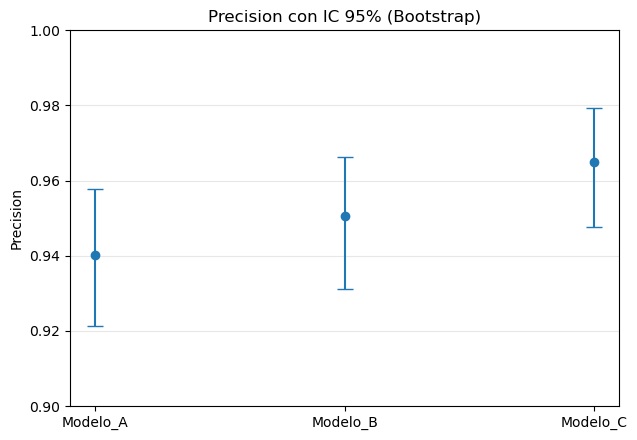

In [20]:
# =========================
# ERROR BARS (IC 95%)
# =========================
import matplotlib.pyplot as plt

models = []
means = []
low = []
high = []

for name, r in results.items():
    models.append(name)
    m = r["precision"]
    lo, hi = r["precision_ci95"]
    means.append(m)
    low.append(m - lo)
    high.append(hi - m)

plt.figure(figsize=(6.5,4.5))
plt.errorbar(models, means, yerr=[low, high], fmt='o', capsize=6)
plt.ylabel("Precision")
plt.title("Precision con IC 95% (Bootstrap)")
plt.ylim(0.9, 1.0)
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()



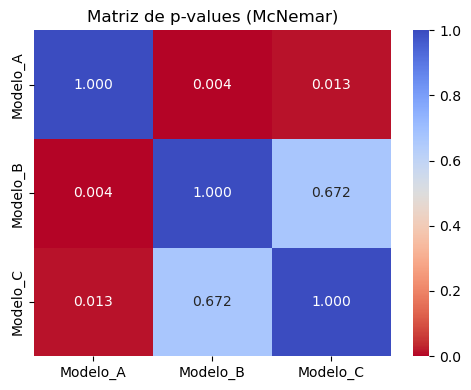

In [22]:
# =========================
# MATRIZ DE P-VALUES (McNemar)
# =========================
import seaborn as sns

names = list(results.keys())
pvals = np.ones((len(names), len(names)))

for i in range(len(names)):
    for j in range(len(names)):
        if i != j:
            pvals[i, j] = mcnemar_pvalue(
                y_true_ref,
                results[names[i]]["y_pred"],
                results[names[j]]["y_pred"]
            )

plt.figure(figsize=(5,4))
sns.heatmap(
    pvals, annot=True, fmt=".3f",
    xticklabels=names, yticklabels=names,
    cmap="coolwarm_r", vmin=0, vmax=1
)
plt.title("Matriz de p-values (McNemar)")
plt.tight_layout()
plt.show()

